# Step 1: Load the Data

In [104]:
import pandas as pd

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Step 2: Explore the Data

In [105]:
print(train.shape, test.shape)
print('-'*50)
print(train.head())
print('-'*50)
print(train.describe())
print('-'*50)
print(train.dtypes)
print('-'*50)
print('Checking for missing values:')
print(train.isnull().sum())
print('-'*50)
print('Checking for duplicates:')
print(train.duplicated().sum())

(8693, 14) (4277, 13)
--------------------------------------------------
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False

# Step 3: Data Preprocessing
## Separate features from target

In [106]:
X_train = train.drop('Transported', axis=1)
y_train = train['Transported']

## Combine train and test datasets to preprocess together

In [107]:
combined = pd.concat([X_train, test], keys=['train', 'test'])

## Split columns with multiple information
Then drop the original columns as they are no longer needed.

In [108]:
combined[['Group', 'NumberInGroup']] = combined['PassengerId'].str.split('_', expand=True)
combined[['Deck', 'Num', 'Side']] = combined['Cabin'].str.split('/', expand=True)
combined.drop(columns=['PassengerId', 'Cabin'], inplace=True)

## Drop likely useless columns
I also tried removing the Name column, but it reduced the accuracy, I believe that same surnames have high chances of the sharing the same target result since they are likely family and had high chances of being together at the moment of the accident.

In [109]:
# TODO CHECK
# combined.drop(columns=['HomePlanet', 'Destination', 'Age', 'VIP'], inplace=True)
print(combined.head())

        HomePlanet CryoSleep  Destination   Age    VIP  RoomService  \
train 0     Europa     False  TRAPPIST-1e  39.0  False          0.0   
      1      Earth     False  TRAPPIST-1e  24.0  False        109.0   
      2     Europa     False  TRAPPIST-1e  58.0   True         43.0   
      3     Europa     False  TRAPPIST-1e  33.0  False          0.0   
      4      Earth     False  TRAPPIST-1e  16.0  False        303.0   

         FoodCourt  ShoppingMall     Spa  VRDeck               Name Group  \
train 0        0.0           0.0     0.0     0.0    Maham Ofracculy  0001   
      1        9.0          25.0   549.0    44.0       Juanna Vines  0002   
      2     3576.0           0.0  6715.0    49.0      Altark Susent  0003   
      3     1283.0         371.0  3329.0   193.0       Solam Susent  0003   
      4       70.0         151.0   565.0     2.0  Willy Santantines  0004   

        NumberInGroup Deck Num Side  
train 0            01    B   0    P  
      1            01    F   0    

## Generate new column "TotalSpending"

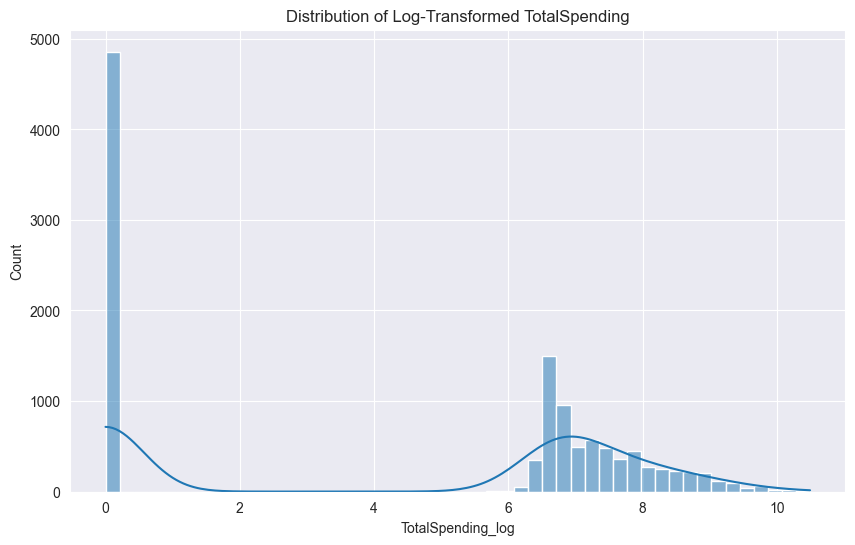

In [110]:
# TODO: consider removing this TotalSpending alltogether

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new feature for total spending
combined['TotalSpending'] = (
        combined['RoomService'] +
        combined['FoodCourt'] +
        combined['ShoppingMall'] +
        combined['Spa'] +
        combined['VRDeck']
)

# Since the distribution of TotalSpending is highly skewed, we apply a log transformation to make it more normally distributed
combined['TotalSpending_log'] = np.log1p(combined['TotalSpending'])  # log1p handles zero values safely
plt.figure(figsize=(10, 6))
sns.histplot(combined['TotalSpending_log'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed TotalSpending')
plt.show()

# Drop original column
combined.drop(columns=['TotalSpending'], inplace=True)

#  TODO consider deleting old spend columns

## Handling missing values

In [111]:
# Fill missing values for categorical columns with a new class "Unknown"
# TODO: for boolean columns consider Filling Missing Values with a Proxy:
# Pros: Sometimes, a missing value can be inferred from other data. For instance, if a passenger has a RoomService charge, they likely weren’t in CryoSleep. This approach allows for more context-aware imputations.
# Cons: Requires domain knowledge and careful implementation to avoid introducing incorrect assumptions.
combined['HomePlanet'] = combined['HomePlanet'].fillna('Unknown')
combined['CryoSleep'] = combined['CryoSleep'].astype(str).fillna('Unknown')
combined['Deck'] = combined['Deck'].fillna('Unknown')
combined['Num'] = combined['Num'].fillna('Unknown')
combined['Side'] = combined['Side'].fillna('Unknown')
combined['Destination'] = combined['Destination'].fillna('Unknown')
combined['VIP'] = combined['VIP'].astype(str).fillna('Unknown')
combined['Name'] = combined['Name'].fillna('Unknown')

# Flag Imputed Values
combined['Age_imputed'] = combined['Age'].isnull().astype(int)
combined['RoomService_imputed'] = combined['RoomService'].isnull().astype(int)
combined['FoodCourt_imputed'] = combined['FoodCourt'].isnull().astype(int)
combined['ShoppingMall_imputed'] = combined['ShoppingMall'].isnull().astype(int)
combined['Spa_imputed'] = combined['Spa'].isnull().astype(int)
combined['VRDeck_imputed'] = combined['VRDeck'].isnull().astype(int)
combined['TotalSpending_log_imputed'] = combined['TotalSpending_log'].isnull().astype(int)

# Fill missing values for numerical columns with the median
combined['Age'] = combined['Age'].fillna(combined['Age'].median())
combined['RoomService'] = combined['RoomService'].fillna(combined['RoomService'].median())
combined['FoodCourt'] = combined['FoodCourt'].fillna(combined['FoodCourt'].median())
combined['ShoppingMall'] = combined['ShoppingMall'].fillna(combined['ShoppingMall'].median())
combined['Spa'] = combined['Spa'].fillna(combined['Spa'].median())
combined['VRDeck'] = combined['VRDeck'].fillna(combined['VRDeck'].median())
combined['TotalSpending_log'] = combined['TotalSpending_log'].fillna(combined['TotalSpending_log'].median())

print(combined.isnull().sum())

HomePlanet                   0
CryoSleep                    0
Destination                  0
Age                          0
VIP                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
Name                         0
Group                        0
NumberInGroup                0
Deck                         0
Num                          0
Side                         0
TotalSpending_log            0
Age_imputed                  0
RoomService_imputed          0
FoodCourt_imputed            0
ShoppingMall_imputed         0
Spa_imputed                  0
VRDeck_imputed               0
TotalSpending_log_imputed    0
dtype: int64


## Handling features bases on their types

In [112]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Define columns.
categorical_features = ['HomePlanet', 'CryoSleep', 'Deck', 'Num', 'Side', 'Destination', 'VIP', 'Name']
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# One-Hot Encoding for categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Scaling for numerical features
numerical_transformer = StandardScaler()

# Combine all transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
    ])

# TODO consider if certain interactions between features might be valuable to include (e.g., interactions between Age and VIP or TotalSpending and HomePlanet). These can be added using PolynomialFeatures or manually creating new interaction features.

## Split combined dataset back into train and test sets

In [113]:
X_train = combined.xs('train')
X_test = combined.xs('test')

# Step 4: Train a Model

In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Split the data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train model TODO try a random classification forest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))  # Replace with your chosen model
])
pipeline.fit(X_train_split, y_train_split)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Deck', 'Num', 'Side',
                                                   'Destination', 'VIP',
                                                   'Name'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

# Step 5: Evaluate the Model

In [115]:
from sklearn.metrics import accuracy_score

y_train_pred = pipeline.predict(X_train_split)
y_val_pred = pipeline.predict(X_val_split)

# Evaluate the model
train_accuracy = accuracy_score(y_train_split, y_train_pred)
val_accuracy = accuracy_score(y_val_split, y_val_pred)

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

# TODO try random classification forest results

Training Accuracy: 1.0000
Validation Accuracy: 0.7987


Best validation accuracy so far: 0.7987

Let's study the importance of reach feature used

In [116]:
importances = pipeline.named_steps['classifier'].feature_importances_
feature_names = preprocessor.get_feature_names_out()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                           Feature  Importance
4                         num__Spa    0.058178
5                      num__VRDeck    0.057686
1                 num__RoomService    0.055443
2                   num__FoodCourt    0.048278
10            cat__CryoSleep_False    0.044684
...                            ...         ...
6247       cat__Name_Mesatz Meplel    0.000000
6150      cat__Name_Megrezn Whibid    0.000000
2266  cat__Name_Ankabit Holatirint    0.000000
8404        cat__Name_Wezno Foraud    0.000000
6830   cat__Name_Pleion Netshaless    0.000000

[8566 rows x 2 columns]


# Step 6: Prepare Submission File

In [117]:
test_predictions = pipeline.predict(X_test)
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Transported': test_predictions})
submission.to_csv('submission.csv', index=False)